In [15]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
import tqdm
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
from xhistogram.xarray import histogram as xhist

In [2]:
ds_traj = xr.open_zarr('/gxfs_work/geomar/smomw662/FESOMparcels_first/data/Parcels_run_1960-01-01.zarr')
ds_traj = ds_traj.chunk({'trajectory':1000, 'obs':300}).persist()
#ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 6GB
Dimensions:     (trajectory: 10000, obs: 30000)
Coordinates:
  * obs         (obs) int32 120kB 0 1 2 3 4 5 ... 29995 29996 29997 29998 29999
  * trajectory  (trajectory) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    lat         (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon         (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 2GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    z           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBCCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.5

/opt/conda/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt

### Coding

In [12]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
lon_unrolled = lon_unrolled.chunk({'trajectory':1000, 'obs':300}).persist()
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((-90, 684), (0, 18))

In [13]:
ds_traj['lon_unrolled'] = lon_unrolled
ds_traj

/opt/conda/lib/python3.11/site-packages/dask/array/core.py:4894: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


<xarray.Dataset> Size: 8GB
Dimensions:       (obs: 30000, trajectory: 10000)
Coordinates:
  * obs           (obs) int32 120kB 0 1 2 3 4 ... 29995 29996 29997 29998 29999
  * trajectory    (trajectory) int64 80kB 0 1 2 3 4 ... 9995 9996 9997 9998 9999
Data variables:
    lat           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    time          (trajectory, obs) datetime64[ns] 2GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    z             (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon_unrolled  (trajectory, obs) float64 2GB dask.array<chunksize=(1000, 299), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBCCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.5

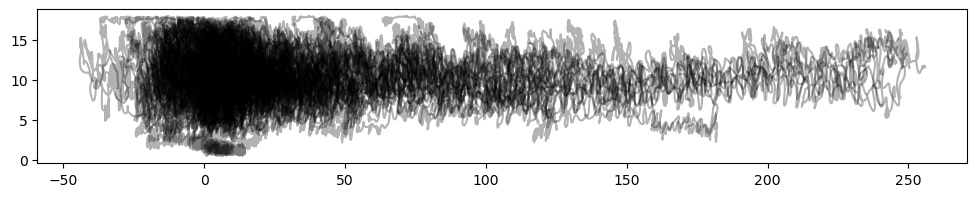

In [28]:
figure,ax = plt.subplots(1,1,figsize=(12,2))

for t in np.random.randint(0,10000,size=(100,)):
    ax.plot(ds_traj.isel(trajectory=t).lon_unrolled, ds_traj.isel(trajectory=t).lat,'k-',alpha=0.2)

In [44]:
# loni = lon_unrolled.isel(trajectory=slice(0,100),obs=slice(0,2999))
# lati = ds_traj.isel(trajectory=slice(0,100),obs=slice(0,2999)).lat

lon_bins = np.linspace(ds_traj.lon_unrolled.min().compute().data[()], ds_traj.lon_unrolled.max().compute().data[()], 350)
lat_bins = np.linspace(ds_traj.lat.min().compute().data[()], ds_traj.lat.max().compute().data[()], 9)

obs_counts = xhist(
    ds_traj.lon_unrolled,
    ds_traj.lat,
    bins=[lon_bins, lat_bins],
    dim=["trajectory", ],
    bin_dim_suffix=""
)

obs_counts

<xarray.DataArray 'histogram_lon_unrolled_lat' (obs: 30000, lon_unrolled: 349,
                                                lat: 8)> Size: 670MB
dask.array<sum-aggregate, shape=(30000, 349, 8), dtype=int64, chunksize=(299, 349, 8), chunktype=numpy.ndarray>
Coordinates:
  * obs           (obs) int32 120kB 0 1 2 3 4 ... 29995 29996 29997 29998 29999
  * lon_unrolled  (lon_unrolled) float64 3kB -86.97 -84.76 ... 680.0 682.2
  * lat           (lat) float64 64B 1.206 3.445 5.684 7.924 ... 12.4 14.64 16.88

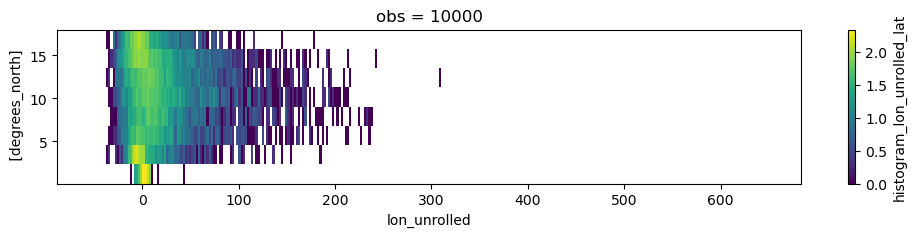

In [38]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
np.log10(obs_counts.isel(obs=10000)).plot(x='lon_unrolled',y='lat')


Text(0, 0.5, 'Latitude')

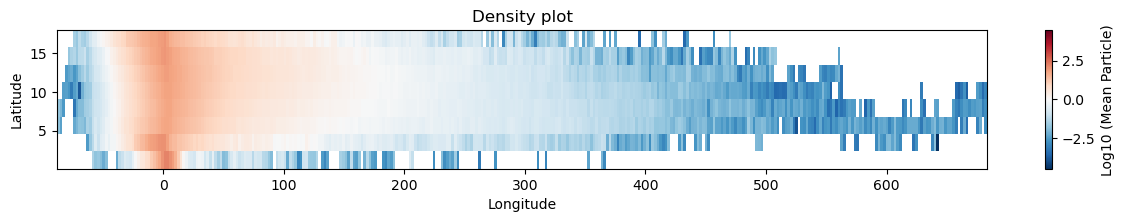

In [56]:
fig,ax = plt.subplots(1,1,figsize=(15,1.8))
np.log10(obs_counts.mean('obs')).plot(x='lon_unrolled',y='lat',ax=ax, cbar_kwargs={'label': 'Log10 (Mean Particle)'})
plt.title('Particle Density plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.colorbar('Log10(Mean Particle)')
## proportional to 600 to 17

### Unrolled without NaN

In [59]:
ds_traj_nn=ds_traj.dropna(dim='trajectory',subset=['z'])
ds_traj_nn

# print(((10000 - 8880)/10_000)*100)

<xarray.Dataset> Size: 7GB
Dimensions:       (obs: 30000, trajectory: 8880)
Coordinates:
  * obs           (obs) int32 120kB 0 1 2 3 4 ... 29995 29996 29997 29998 29999
  * trajectory    (trajectory) int64 71kB 1 2 3 5 8 ... 9994 9995 9997 9998 9999
Data variables:
    lat           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    time          (trajectory, obs) datetime64[ns] 2GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    z             (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon_unrolled  (trajectory, obs) float64 2GB dask.array<chunksize=(1000, 299), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBCCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [60]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj_nn.lon.diff('obs') < -4) - 4.5 * (ds_traj_nn.lon.diff('obs') > 4)
lon_unrolled = (ds_traj_nn.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
lon_unrolled = lon_unrolled.chunk({'trajectory':1000, 'obs':300}).persist()
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((-90, 684), (0, 18))

In [61]:
ds_traj_nn['lon_unrolled'] = lon_unrolled
ds_traj_nn

<xarray.Dataset> Size: 7GB
Dimensions:       (obs: 30000, trajectory: 8880)
Coordinates:
  * obs           (obs) int32 120kB 0 1 2 3 4 ... 29995 29996 29997 29998 29999
  * trajectory    (trajectory) int64 71kB 1 2 3 5 8 ... 9994 9995 9997 9998 9999
Data variables:
    lat           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon           (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    time          (trajectory, obs) datetime64[ns] 2GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    z             (trajectory, obs) float32 1GB dask.array<chunksize=(1000, 300), meta=np.ndarray>
    lon_unrolled  (trajectory, obs) float64 2GB dask.array<chunksize=(1000, 299), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBCCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [73]:
lon_bins = np.linspace(ds_traj_nn.lon_unrolled.min().compute().data[()], ds_traj_nn.lon_unrolled.max().compute().data[()], 350)
lat_bins = np.linspace(ds_traj_nn.lat.min().compute().data[()], ds_traj_nn.lat.max().compute().data[()], 9)

obs_counts_nn = xhist(
    ds_traj_nn.lon_unrolled,
    ds_traj_nn.lat,
    bins=[lon_bins, lat_bins],
    dim=["trajectory", ],
    bin_dim_suffix=""
)

log_obs = np.log10(obs_counts_nn.mean('obs')+1)

Text(0, 0.5, 'Latitude')

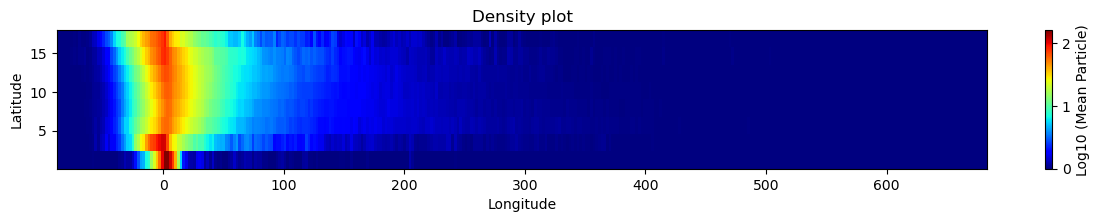

In [74]:
fig,ax = plt.subplots(1,1,figsize=(15,1.8))
log_obs.plot(x='lon_unrolled',y='lat',ax=ax, cbar_kwargs={'label': 'Log10 (Mean Particle)'},cmap=plt.cm.jet)
plt.title('Density plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [ ]:
# plt.hist2d(loni, lati, bins=(50, 50), cmap=plt.cm.jet)
# plt.title('bins = (50, 50)')

In [ ]:
# # bins = [np.linspace(min,max,ts), np.linspace(min,max,ts)]


# # Flatten loni and lati into 1D arrays
# loni_flat = np.concatenate(loni)
# lati_flat = np.concatenate(lati)

# # Create a 2D histogram
# hist, xedges, yedges = np.histogram2d(loni_flat, lati_flat, bins=(50, 50))

# # Apply logarithmic scale to the histogram counts
# hist_log = np.log10(hist + 1)  # Add 1 to avoid log(0)

# # Plot the 2D histogram
# plt.figure(figsize=(10, 8))
# plt.pcolormesh(xedges, yedges, hist_log.T, cmap=plt.cm.jet)
# plt.colorbar(label="Log10(Counts + 1)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Density plot")
# plt.show()